In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import ast



dataset_path = r"..\..\datasets\petr4_options_data\processed_petr4_options.csv"
european_calls = pd.read_csv(dataset_path)
european_calls = european_calls[european_calls["type"] == "CALL"]
european_calls

,symbol,time,spot,type,due_date,strike,premium,maturity_type,days_to_maturity,moneyness,delta,gamma,vega,theta,rho,volatility,poe,bs,variação
1,PETRK233,2022-11-07T00:00:00.000Z,"{'price': 27.15, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,7.02,20.78,EUROPEAN,8,ITM,1.0,0.0,0.0,-0.000557,0.002227,0.0,100.0,20.1345,-0.6455
2,PETRK233,2022-11-09T00:00:00.000Z,"{'price': 26.9, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,7.02,20.50,EUROPEAN,7,ITM,1.0,0.0,0.0,-0.000557,0.001949,0.0,100.0,19.8839,-0.6161
3,PETRK233,2022-11-04T00:00:00.000Z,"{'price': 28.3, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,7.02,21.80,EUROPEAN,10,ITM,1.0,0.0,0.0,-0.000557,0.002784,0.0,100.0,21.2856,-0.5144
6,PETRK145,2022-11-16T00:00:00.000Z,"{'price': 27.15, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,14.52,12.96,EUROPEAN,2,ITM,1.0,0.0,0.0,-0.001152,0.001152,0.0,100.0,12.6323,-0.3277
7,PETRK165,2022-11-17T00:00:00.000Z,"{'price': 27.16, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,16.52,10.93,EUROPEAN,1,ITM,1.0,0.0,0.0,-0.001311,0.000655,0.0,100.0,10.6413,-0.2887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9060,PETRK292,2022-11-11T00:00:00.000Z,"{'price': 26.99, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,13.02,13.07,EUROPEAN,5,ITM,1.0,0.0,0.0,-0.001033,0.002582,0.0,100.0,13.9752,0.9052
9073,PETRL317,2022-11-11T00:00:00.000Z,"{'price': 26.99, 'symbol': 'PETR4'}",CALL,2022-12-16T00:00:00.000Z,13.02,13.07,EUROPEAN,25,ITM,1.0,0.0,0.0,-0.001031,0.012891,0.0,100.0,13.9958,0.9258
9083,PETRL206,2022-11-11T00:00:00.000Z,"{'price': 26.99, 'symbol': 'PETR4'}",CALL,2022-12-16T00:00:00.000Z,17.52,8.56,EUROPEAN,25,ITM,1.0,0.0,0.0,-0.001388,0.017346,0.0,100.0,9.5047,0.9447
9090,PETRL21,2022-11-11T00:00:00.000Z,"{'price': 26.99, 'symbol': 'PETR4'}",CALL,2022-12-16T00:00:00.000Z,9.07,16.98,EUROPEAN,25,ITM,1.0,0.0,0.0,-0.000718,0.008980,0.0,100.0,17.9380,0.9580


In [2]:
# Extract the 'price' value from the 'spot' column
def extract_price(spot_value):
    try:
        parsed = ast.literal_eval(spot_value)  # Parse the string as a dictionary
        return parsed.get("price")  # Extract 'price'
    except (ValueError, SyntaxError, AttributeError):
        return None  # Return None if parsing fails

# Apply extraction
european_calls["spot_price"] = european_calls["spot"].apply(extract_price)

european_calls = european_calls[european_calls["type"] == "CALL"]
european_calls

,symbol,time,spot,type,due_date,strike,premium,maturity_type,days_to_maturity,moneyness,delta,gamma,vega,theta,rho,volatility,poe,bs,variação,spot_price
1,PETRK233,2022-11-07T00:00:00.000Z,"{'price': 27.15, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,7.02,20.78,EUROPEAN,8,ITM,1.0,0.0,0.0,-0.000557,0.002227,0.0,100.0,20.1345,-0.6455,27.15
2,PETRK233,2022-11-09T00:00:00.000Z,"{'price': 26.9, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,7.02,20.50,EUROPEAN,7,ITM,1.0,0.0,0.0,-0.000557,0.001949,0.0,100.0,19.8839,-0.6161,26.90
3,PETRK233,2022-11-04T00:00:00.000Z,"{'price': 28.3, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,7.02,21.80,EUROPEAN,10,ITM,1.0,0.0,0.0,-0.000557,0.002784,0.0,100.0,21.2856,-0.5144,28.30
6,PETRK145,2022-11-16T00:00:00.000Z,"{'price': 27.15, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,14.52,12.96,EUROPEAN,2,ITM,1.0,0.0,0.0,-0.001152,0.001152,0.0,100.0,12.6323,-0.3277,27.15
7,PETRK165,2022-11-17T00:00:00.000Z,"{'price': 27.16, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,16.52,10.93,EUROPEAN,1,ITM,1.0,0.0,0.0,-0.001311,0.000655,0.0,100.0,10.6413,-0.2887,27.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9060,PETRK292,2022-11-11T00:00:00.000Z,"{'price': 26.99, 'symbol': 'PETR4'}",CALL,2022-11-18T00:00:00.000Z,13.02,13.07,EUROPEAN,5,ITM,1.0,0.0,0.0,-0.001033,0.002582,0.0,100.0,13.9752,0.9052,26.99
9073,PETRL317,2022-11-11T00:00:00.000Z,"{'price': 26.99, 'symbol': 'PETR4'}",CALL,2022-12-16T00:00:00.000Z,13.02,13.07,EUROPEAN,25,ITM,1.0,0.0,0.0,-0.001031,0.012891,0.0,100.0,13.9958,0.9258,26.99
9083,PETRL206,2022-11-11T00:00:00.000Z,"{'price': 26.99, 'symbol': 'PETR4'}",CALL,2022-12-16T00:00:00.000Z,17.52,8.56,EUROPEAN,25,ITM,1.0,0.0,0.0,-0.001388,0.017346,0.0,100.0,9.5047,0.9447,26.99
9090,PETRL21,2022-11-11T00:00:00.000Z,"{'price': 26.99, 'symbol': 'PETR4'}",CALL,2022-12-16T00:00:00.000Z,9.07,16.98,EUROPEAN,25,ITM,1.0,0.0,0.0,-0.000718,0.008980,0.0,100.0,17.9380,0.9580,26.99


In [3]:
# Defining now, as it comes in handy :)
def evaluate_model(true, predicted, model_name):
    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    r2 = r2_score(true, predicted)
    percent_error = np.abs((true - predicted) / true) * 100
    pe5 = np.mean(percent_error <= 5) * 100  # Percentage of predictions within 5% error
    pe10 = np.mean(percent_error <= 10) * 100  # Percentage of predictions within 10% error
    pe20 = np.mean(percent_error <= 20) * 100  # Percentage of predictions within 20% error

    
    print(f"\n{model_name} Performance:")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"  R^2: {r2}")
    print(f"  PE5: {pe5:.2f}%")
    print(f"  PE10: {pe10:.2f}%")
    print(f"  PE20: {pe20:.2f}%")

data = european_calls
# Stratified split
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in stratified_split.split(data, data['moneyness']):
    train_data = data.iloc[train_idx]
    test_data = data.iloc[test_idx]

# Add Risk-Free Rate (constant for November 2022)
risk_free_rate = 0.1375  # Selic rate for Brazil in November 2022: https://g1.globo.com/economia/noticia/2022/08/03/copom-eleva-selic-para-1375percent-e-juro-basico-da-economia-chega-ao-maior-patamar-em-seis-anos.ghtml
train_data['RISK_FREE_RATE'] = risk_free_rate
test_data['RISK_FREE_RATE'] = risk_free_rate

# Handle outliers in PREMIUM by capping extreme values
price_upper_limit = train_data['premium'].quantile(0.99)
price_lower_limit = train_data['premium'].quantile(0.01)
train_data['premium'] = train_data['premium'].clip(lower=price_lower_limit, upper=price_upper_limit)

# Define features

features = ['rho',
     'theta',
    'gamma',
    'spot_price',
    "strike",
    "days_to_maturity",
    "volatility",
            
]
target = 'premium'

# Drop MONEYNESS_CATEGORY
train_data = train_data.drop(columns=['moneyness'])
test_data = test_data.drop(columns=['moneyness'])

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data[features])
X_test = scaler.transform(test_data[features])
y_train = train_data[target]
y_test = test_data[target]


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_19540\3320436892.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['RISK_FREE_RATE'] = risk_free_rate
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_19540\3320436892.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['RISK_FREE_RATE'] = risk_free_rate
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_19540\3320436892.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [4]:
# ------------------------- MLP Model ------------------------- #
# I already know from literature the reasonableness of using MLP in this type of data, so I don't really bother
# and will go directly to Hyperparameter Tuning. 
mlp = MLPRegressor() 

param_distributions = {
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'hidden_layer_sizes': [(128, 64), (64, 32), (128, 128)],
    'alpha': [0.0001, 0.01, 0.1],
    'activation': ['relu', 'tanh']
}

# Randomized Search is better, as 1) it's faster, 2) I don't want to destroy my laptop.
random_search = RandomizedSearchCV( 
    estimator = mlp,
    param_distributions=param_distributions,
    n_iter = 15,
    scoring = "neg_mean_squared_error",
    random_state = 42,
    verbose = 2,
    n_jobs = -1,
    
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:")
print(best_params)

best_mlp = random_search.best_estimator_
mlp_predictions = best_mlp.predict(X_test)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_percept

Best Hyperparameters:
{'solver': 'sgd', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (64, 32), 'alpha': 0.01, 'activation': 'tanh'}


In [5]:
"""
Hyperparameters:
Best Hyperparameters:
{'solver': 'sgd', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (64, 32), 'alpha': 0.001, 'activation': 'tanh'}

"""

# Just not to write too much later:
mlp = best_mlp

# Evaluation:
evaluate_model(y_test, mlp_predictions, "MLP")


MLP Performance:
  MSE: 0.060076230679785736
  MAE: 0.09144382200419812
  R^2: 0.99656900665685
  PE5: 55.04%
  PE10: 64.30%
  PE20: 71.74%



Residuals Analysis:
Mean Residual: 0.038818293292746525
Standard Deviation of Residuals: 0.2422113538679678


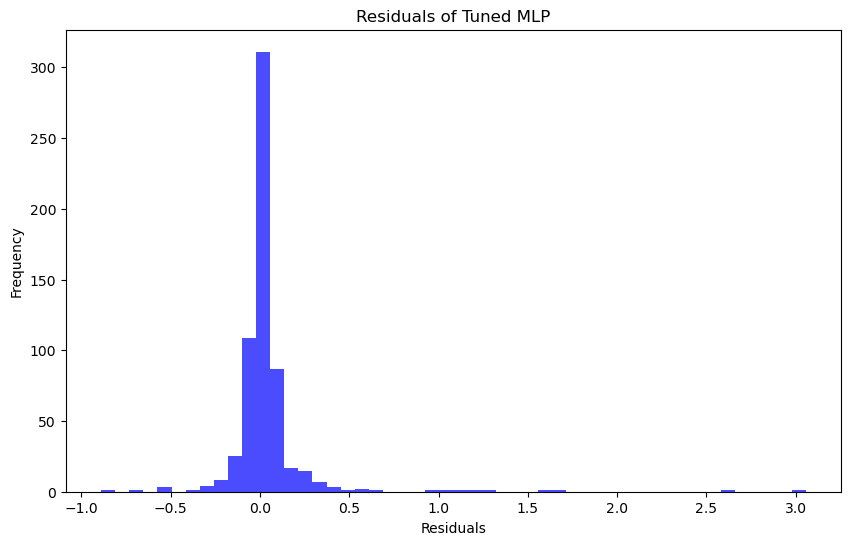

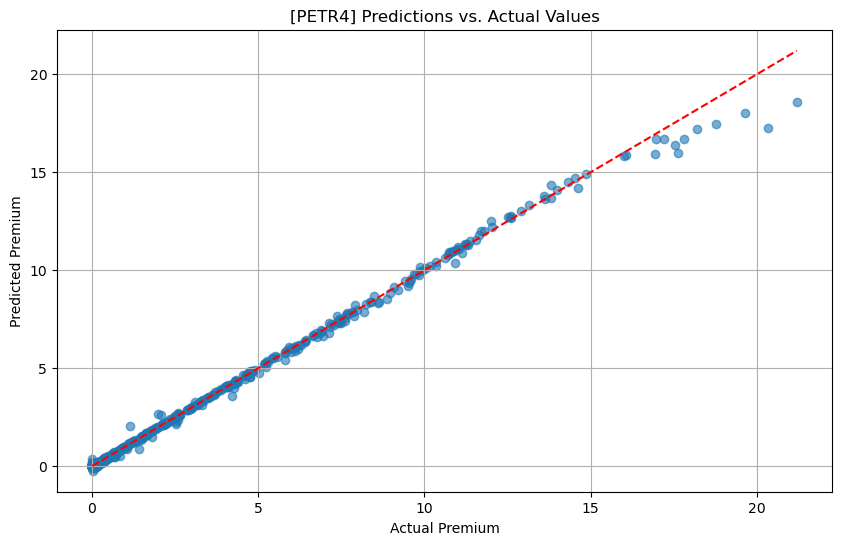

In [6]:
# Also check on residuals
residuals = y_test - mlp_predictions
print("\nResiduals Analysis:")
print("Mean Residual:", residuals.mean())
print("Standard Deviation of Residuals:", residuals.std())

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='blue', alpha=0.7)
plt.title('Residuals of Tuned MLP')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, mlp_predictions, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Premium")
plt.ylabel("Predicted Premium")
plt.title("[PETR4] Predictions vs. Actual Values")
plt.grid()
plt.show()

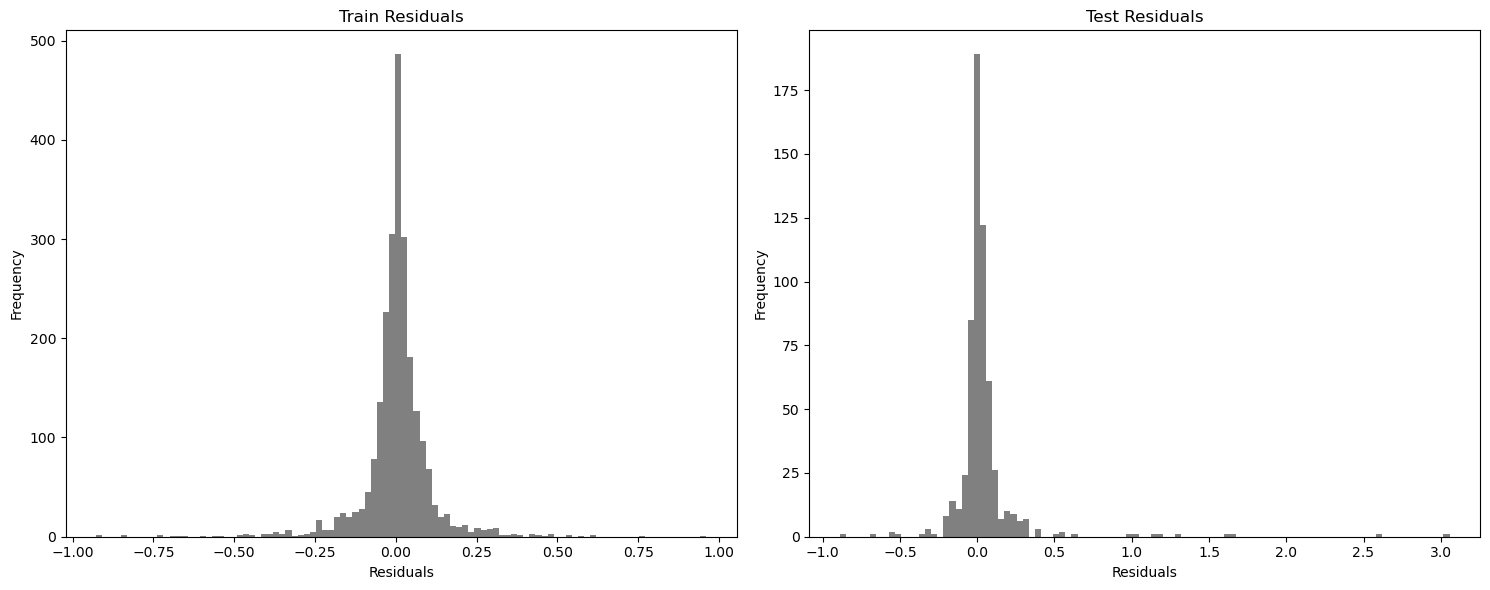

In [7]:
# The residuals are around 0, which is good enough.
# I want to check if the model is overfitting in any form. 
# First, I'll start by checking the residuals of test/train sets.

train_predictions = mlp.predict(X_train)
train_residuals = y_train - train_predictions

test_residuals = y_test - mlp_predictions

plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
plt.hist(train_residuals, bins = 100, color = 'gray')
plt.title("Train Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(test_residuals, bins = 100, color = 'gray')
plt.title("Test Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")


plt.tight_layout()
plt.show() # I don't want a bunch of arrays showing up

So far, good enough. The model does not seem to overfit nor to be very overperformed by neither sets. The last metric I'll check is the Learning curve.

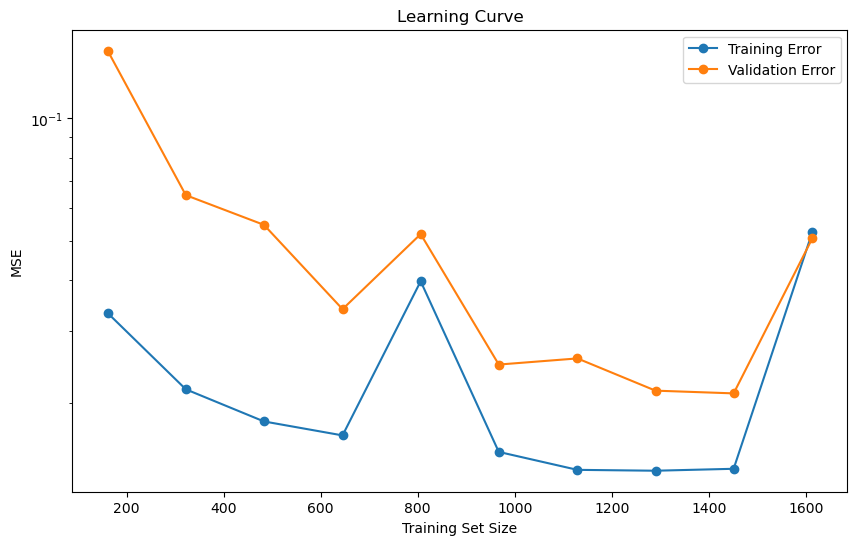

In [8]:
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=best_mlp,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Negative MSE to positive
train_scores_mean = -np.mean(train_scores, axis=1)
valid_scores_mean = -np.mean(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error', marker='o')
plt.plot(train_sizes, valid_scores_mean, label='Validation Error', marker='o')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.yscale("log")
plt.ylabel('MSE')
plt.legend()
plt.show()


The model is definitely not overfitting, as they converge the MSE together and the gap between them is quite minimal.

In [9]:
itm_options = european_calls[european_calls["moneyness"] == "ITM"]
atm_options = european_calls[european_calls["moneyness"] == "ATM"]
otm_options = european_calls[european_calls["moneyness"] == "OTM"]
# Function to train an MLP model with feature scaling
def train_mlp_with_scaling(data, features, target, scaler_type='standard'):
    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaler_type. Choose 'standard' or 'minmax'.")
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', solver='adam',
                         learning_rate_init=0.001, max_iter=500, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_scaled)

    return model, scaler, X_test_scaled, y_test, y_pred

features = ["strike", "days_to_maturity", "volatility"]
target = "premium"

mlp_itm, scaler_itm, X_test_scaled_itm, y_test_itm, y_pred_itm = train_mlp_with_scaling(itm_options, features, target, scaler_type='robust')
evaluate_model(y_test_itm, y_pred_itm, "ITM MLP with Scaling")

mlp_atm, scaler_atm, X_test_scaled_atm, y_test_atm, y_pred_atm = train_mlp_with_scaling(atm_options, features, target, scaler_type='robust')
evaluate_model(y_test_atm, y_pred_atm, "ATM MLP with Scaling")

mlp_otm, scaler_otm, X_test_scaled_otm, y_test_otm, y_pred_otm = train_mlp_with_scaling(otm_options, features, target, scaler_type='minmax')
evaluate_model(y_test_otm, y_pred_otm, "OTM MLP with Scaling")

itm_test = itm_options.loc[y_test_itm.index]
atm_test = atm_options.loc[y_test_atm.index]
otm_test = otm_options.loc[y_test_otm.index]

itm_test["predicted_premium"] = y_pred_itm
atm_test["predicted_premium"] = y_pred_atm
otm_test["predicted_premium"] = y_pred_otm

final_predictions = pd.concat([itm_test, atm_test, otm_test])

print(final_predictions[["premium", "predicted_premium", "moneyness"]].head())



ITM MLP with Scaling Performance:
  MSE: 1.5390168938300643
  MAE: 0.9416458679564267
  R^2: 0.9080565881008272
  PE5: 23.67%
  PE10: 41.55%
  PE20: 77.78%

ATM MLP with Scaling Performance:
  MSE: 0.09483274341335544
  MAE: 0.22488941819077524
  R^2: 0.9338111080615921
  PE5: 30.26%
  PE10: 52.63%
  PE20: 77.63%

OTM MLP with Scaling Performance:
  MSE: 0.07526609581202218
  MAE: 0.17960744022902672
  R^2: 0.8609407734417454
  PE5: 6.19%
  PE10: 9.91%
  PE20: 17.96%
      premium  predicted_premium moneyness
3075     4.61           4.341323       ITM
4349    13.56          13.318361       ITM
5854     2.70           2.592408       ITM
1560     7.84           7.452444       ITM
5449     4.28           3.557357       ITM


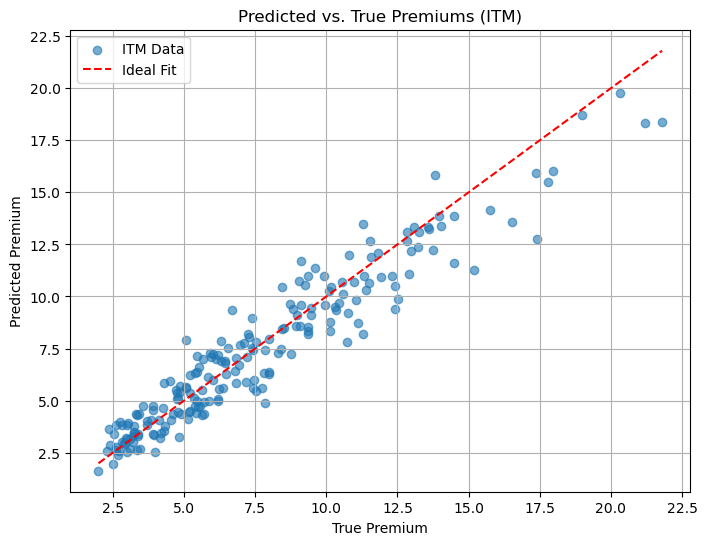

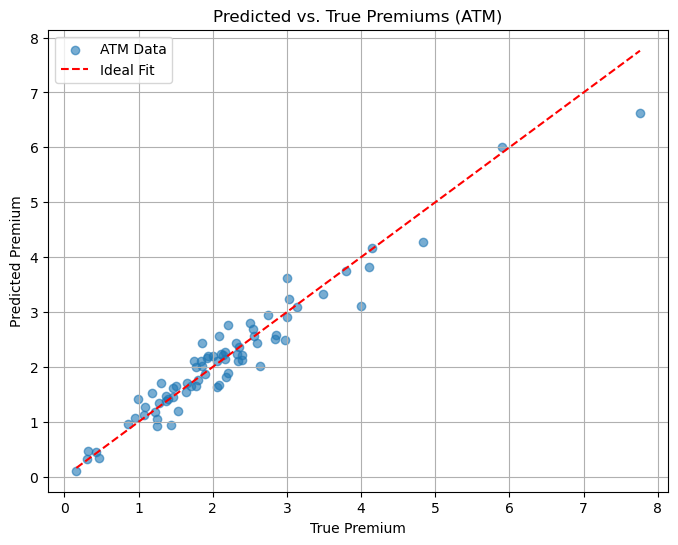

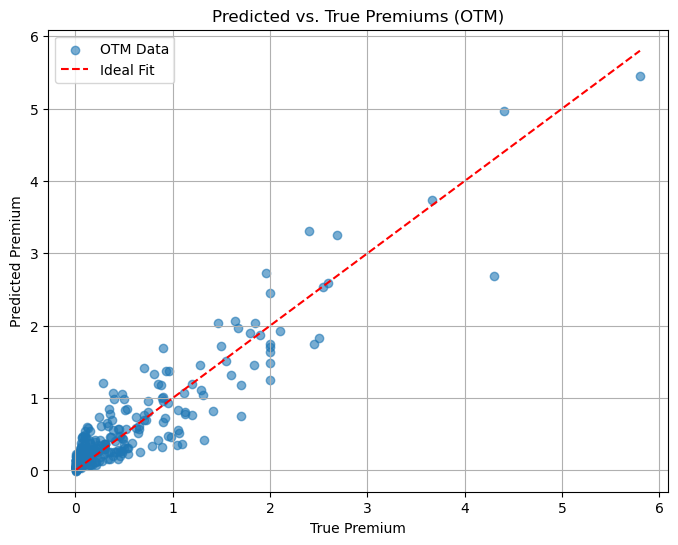

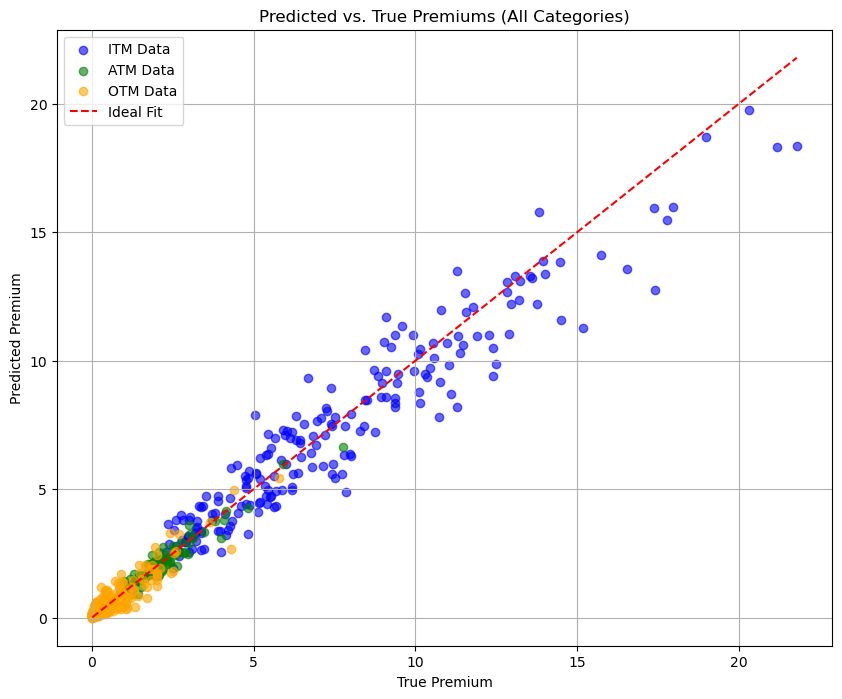

In [10]:
# Define a helper function to plot predicted vs true prices for each category
def plot_predicted_vs_true(data, category_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(data["premium"], data["predicted_premium"], alpha=0.6, label=f'{category_name} Data')
    plt.plot([data["premium"].min(), data["premium"].max()],
             [data["premium"].min(), data["premium"].max()],
             color='red', linestyle='--', label='Ideal Fit')
    plt.title(f"Predicted vs. True Premiums ({category_name})")
    plt.xlabel("True Premium")
    plt.ylabel("Predicted Premium")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot results for ITM, ATM, and OTM separately
plot_predicted_vs_true(itm_test, "ITM")
plot_predicted_vs_true(atm_test, "ATM")
plot_predicted_vs_true(otm_test, "OTM")

# Plot combined results for all moneyness categories
plt.figure(figsize=(10, 8))
plt.scatter(itm_test["premium"], itm_test["predicted_premium"], alpha=0.6, label='ITM Data', color='blue')
plt.scatter(atm_test["premium"], atm_test["predicted_premium"], alpha=0.6, label='ATM Data', color='green')
plt.scatter(otm_test["premium"], otm_test["predicted_premium"], alpha=0.6, label='OTM Data', color='orange')
plt.plot([final_predictions["premium"].min(), final_predictions["premium"].max()],
         [final_predictions["premium"].min(), final_predictions["premium"].max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.title("Predicted vs. True Premiums (All Categories)")
plt.xlabel("True Premium")
plt.ylabel("Predicted Premium")
plt.legend()
plt.grid(True)
plt.show()